# OHCL - Analytics

### Import Library

In [20]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
import seaborn as sns
import math

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [21]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [22]:
data = dataset.copy()

In [23]:
data["ma_line"] = data["Close"].rolling(20).mean()
data['above_ma'] = data.apply(lambda r: 1 if r['Close'] > r['ma_line'] else 0, axis=1)
data['below_ma'] = data.apply(lambda r: 1 if r['Close'] < r['ma_line'] else 0, axis=1)
data['total_above_ma'] = data['above_ma'].rolling(150).sum()
data['total_below_ma'] = data['below_ma'].rolling(150).sum()
data['trend_diff'] = data['total_above_ma'] - data['total_below_ma']
data['ibs'] = data.apply(
    lambda r: 0 if (r['High'] == r['Low']) else abs(r['Close'] - r['Low']) / (r['High'] - r['Low']), axis=1)

In [24]:
def bar9h(tick):
    tick=tick[(tick.index.hour == 9) & (tick.index.minute == 0)]
    if len(tick):
        return tick[0]
def bar14h(tick):
    tick=tick[(tick.index.hour == 14) & (tick.index.minute == 0)]
    if len(tick):
        return tick[0]
data['Close_9h'] = data['Close']
data['Close_14h'] = data['Close']
data["RSI"] = ta.rsi(data["Close"], length=14)
day_data = data.resample('D').agg({
        'Open': 'first',
        'Close': 'last',
        'High': 'max',
        'Low': 'min',
        'Close_9h': bar9h,
        'Close_14h': bar14h,
        'RSI': bar9h,
        'trend_diff': bar9h,
        'total_above_ma': bar9h,
        'total_below_ma': bar9h,
        'ibs': bar9h
    })
day_data.dropna(subset=['Close'], inplace=True)

In [25]:
# 1 means first_bar in high area, 2 means first_bar in low area, else 0
def get_first_bar_group(r):
    if r['Close_9h'] > r['High'] - 3:
        group = 1
    elif r['Close_9h'] < r['Low'] + 3:
        group = 2
    else:
        group = 0
    return group
day_data['first_bar_group'] = day_data.apply(lambda r: get_first_bar_group(r), axis=1)

In [26]:
len(day_data[day_data['first_bar_group'] == 0])

591

In [27]:
len(day_data[day_data['first_bar_group'] == 1])

473

In [28]:
len(day_data[day_data['first_bar_group'] == 2])

426

In [29]:
day_data = day_data[(day_data.Close != day_data.Close_14h) & (day_data.High != day_data.Close_14h) & (day_data.High != day_data.Close)]
day_data['diff_overnight'] = 1000*(day_data.Close_9h - day_data.Close.shift(1)) / day_data.Close.shift(1)
day_data['diff_14h'] = 1000*(day_data.Close_9h - day_data.Close_14h.shift(1)) / day_data.Close_14h.shift(1)
day_data['rate_a'] = (day_data.Close_9h - day_data.Close_14h.shift(1)) / (day_data.High.shift(1) - day_data.Low.shift(1))
day_data['rate_b'] = (day_data.Close_9h - day_data.Open.shift(1)) / day_data.Open.shift(1)
day_data['rate_c'] = (day_data.Close_9h - day_data.Close_9h.shift(1)) / (day_data.High.shift(1) - day_data.Low.shift(1))
day_data['rate_d'] = (day_data.Close_9h - day_data.Close.shift(1)) / (day_data.Close.shift(1) - day_data.Close_14h.shift(1))
day_data['14h_low_high'] = (day_data.Close_14h.shift(1) - day_data.Low.shift(1)) / (day_data.High.shift(1) - day_data.Close_14h.shift(1))
day_data['14h45_low_high'] = (day_data.Close.shift(1) - day_data.Low.shift(1)) / (day_data.High.shift(1) - day_data.Close.shift(1))
day_data['9h_lastclose'] = 1000*(day_data.Close_9h - day_data.Open) / day_data.Close.shift(1)
day_data['9h_last14h'] = 1000*(day_data.Close_9h - day_data.Open) / day_data.Close_14h.shift(1)
day_data['rate_e'] = (day_data.Open - day_data.Open.shift(1)) / (day_data.High.shift(1) - day_data.Low.shift(1))
day_data['rate_f'] = 1000 * (day_data.Close_9h - day_data.Close.shift(1)) / (day_data.High.shift(1) + day_data.Low.shift(1))
day_data['rate_g'] = 1000 * (day_data.Close_9h - day_data.Close_14h.shift(1)) / (day_data.High.shift(1) + day_data.Low.shift(1))

In [30]:
day_data.dropna(inplace=True)

In [31]:
group_high = day_data[day_data.first_bar_group==1]
group_low = day_data[day_data.first_bar_group==2]
group_none = day_data[day_data.first_bar_group==0]

In [32]:
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.constrained_layout.use'] = True

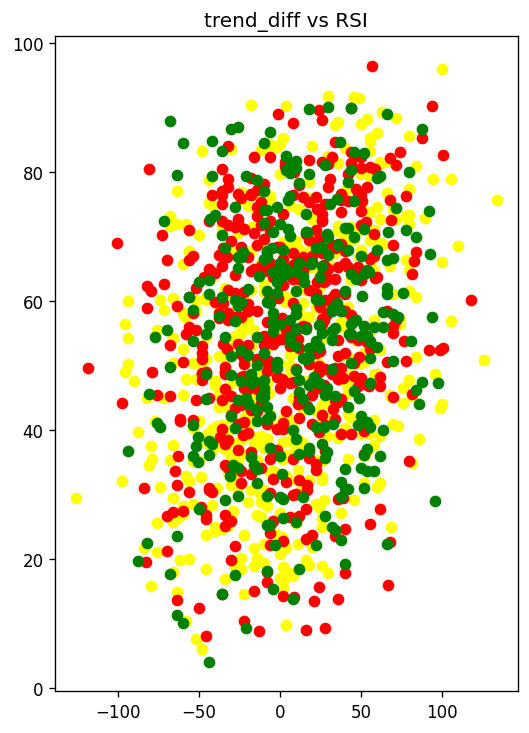

In [33]:
plt.rcParams['figure.figsize'] = [12, 6]
selected_columns = ['trend_diff', 'RSI']
COL_GRID_PLOT = 3
l = len(selected_columns)
total_grid = (l*(l-1))/2
ROW_GRID_PLOT = math.ceil(total_grid/COL_GRID_PLOT)
index = 1
for k in range(len(selected_columns)):
    for h in range(k+1, len(selected_columns)):
        column_x = selected_columns[k]
        column_y = selected_columns[h]
        plt.subplot(ROW_GRID_PLOT, COL_GRID_PLOT, index)
        plt.title("{} vs {}".format(column_x, column_y))
        plt.scatter(group_none[column_x], group_none[column_y], c='yellow')
        plt.scatter(group_high[column_x], group_high[column_y], c='red')
        plt.scatter(group_low[column_x], group_low[column_y], c='green')
        index = index+1

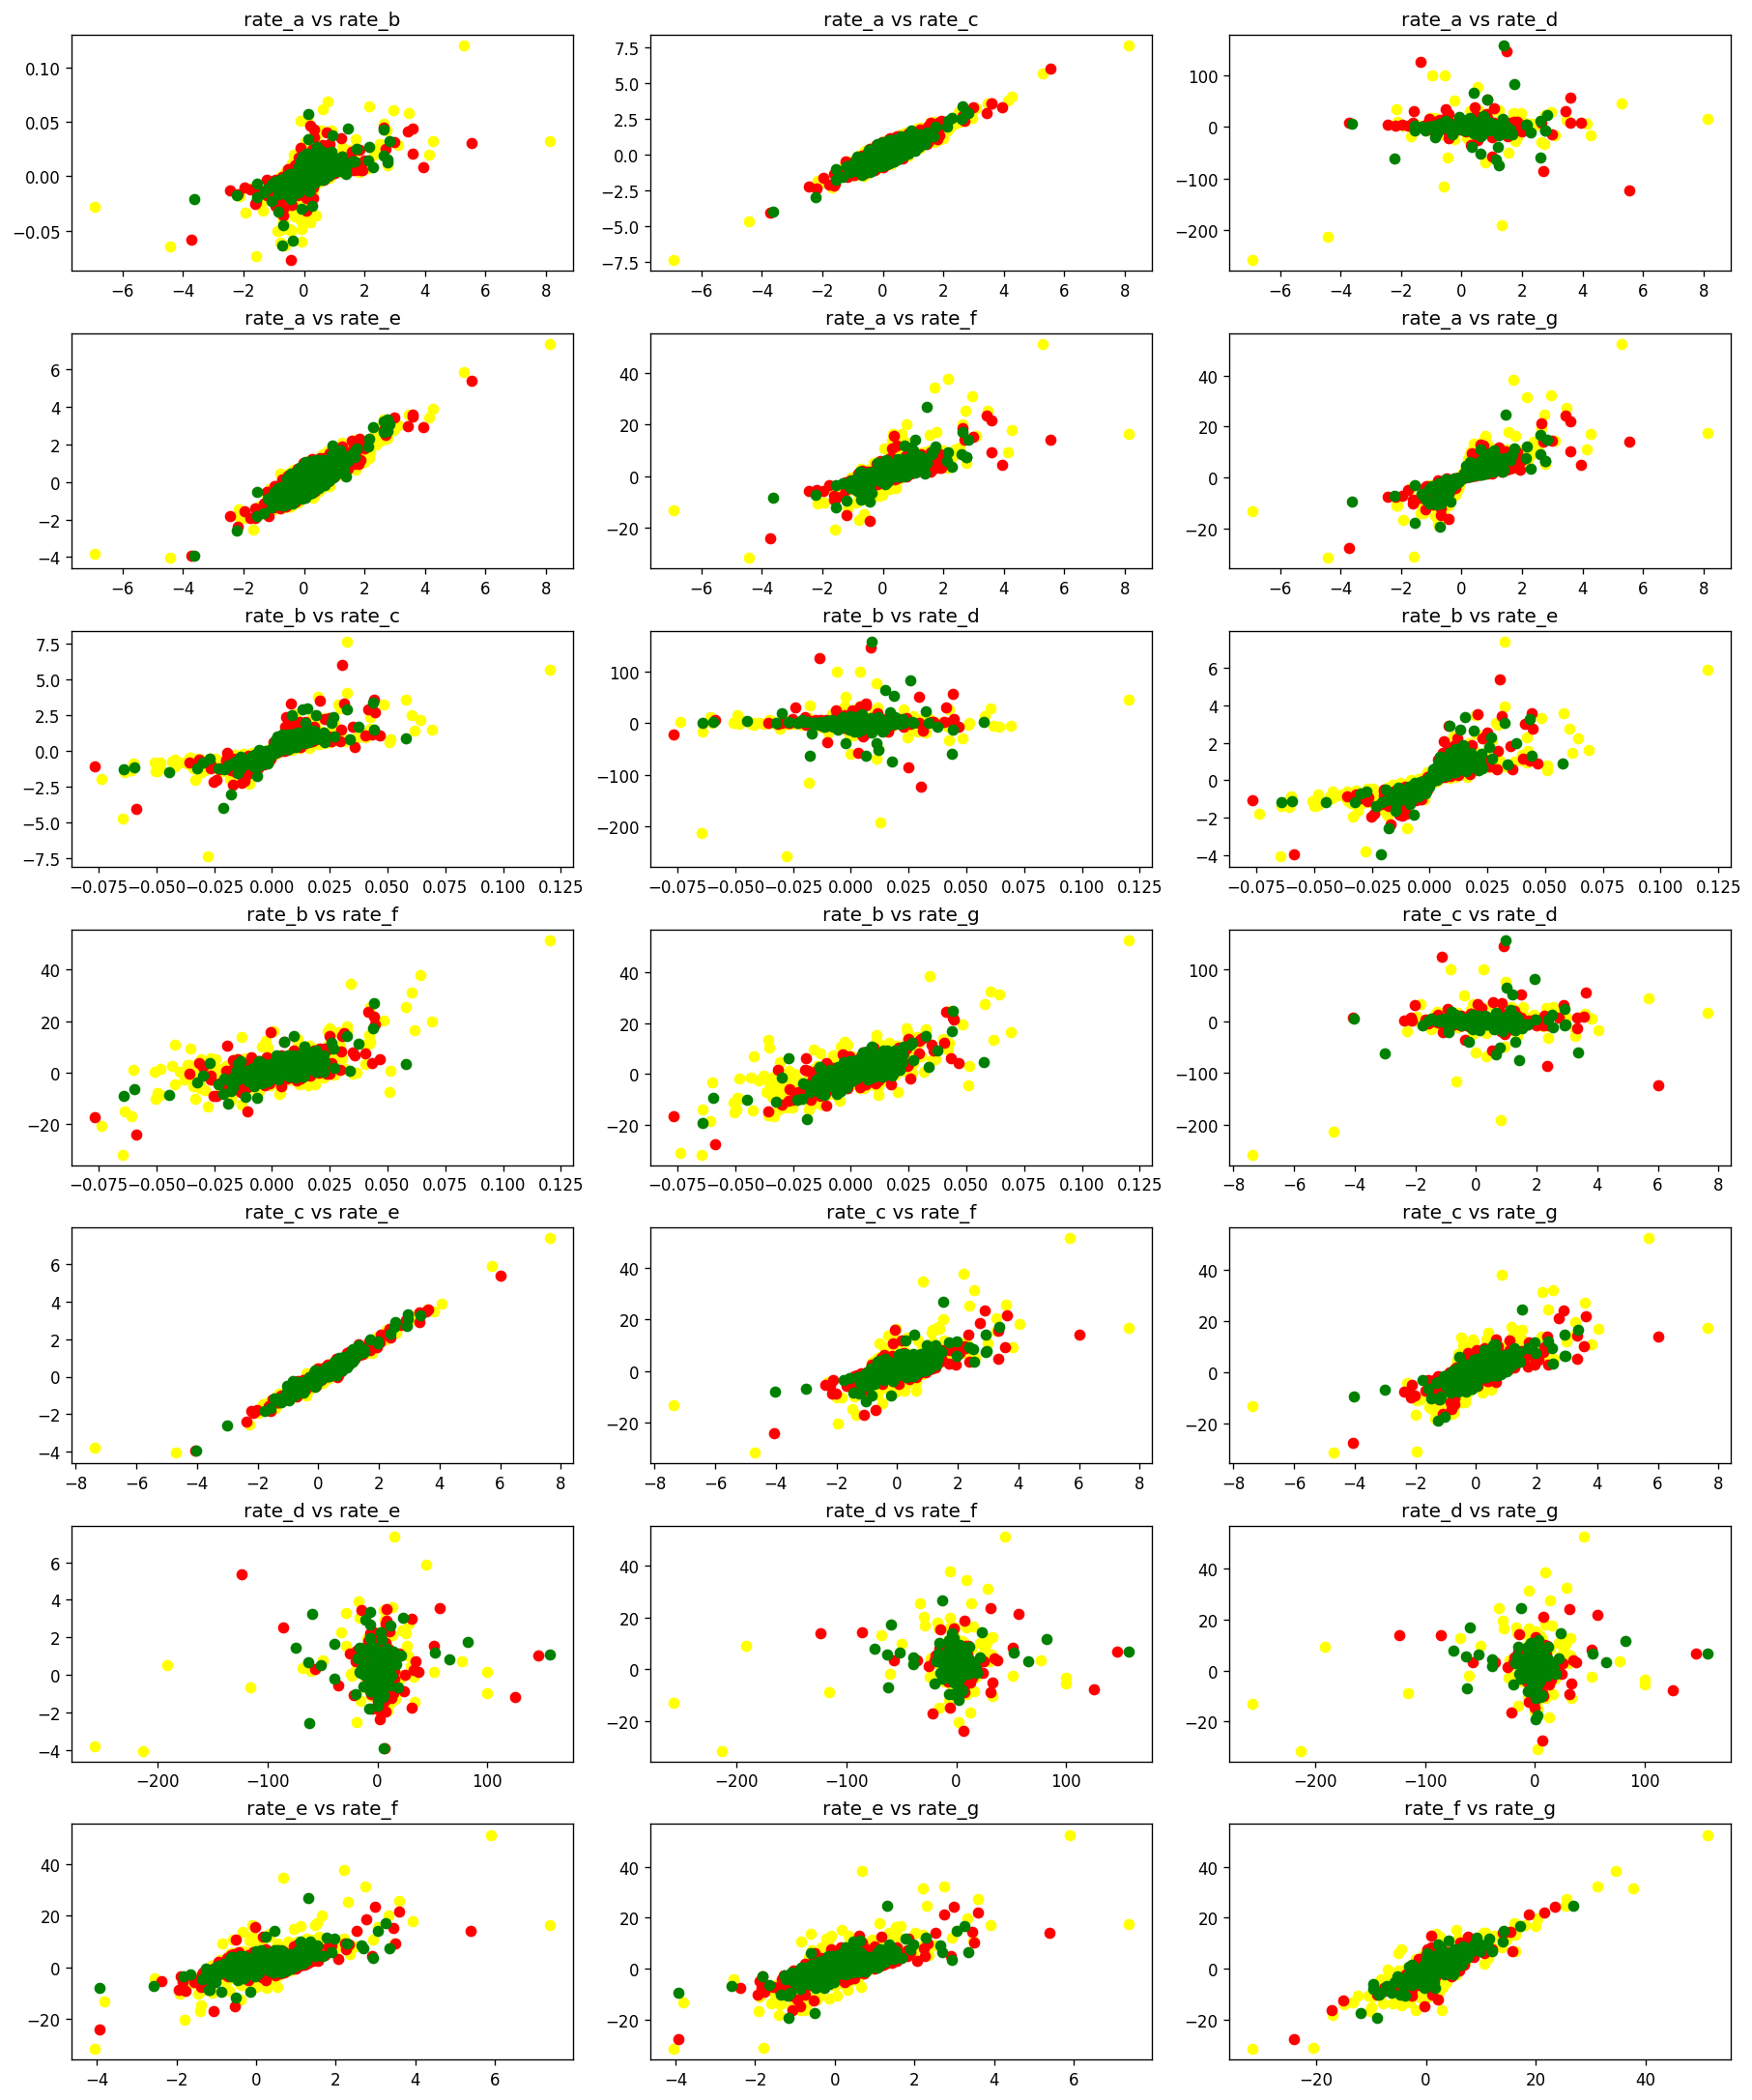

In [34]:
plt.rcParams['figure.figsize'] = [15, 18]
selected_columns = ['rate_a', 'rate_b', 'rate_c', 'rate_d', 'rate_e', 'rate_f', 'rate_g']
COL_GRID_PLOT = 3
l = len(selected_columns)
total_grid = (l*(l-1))/2
ROW_GRID_PLOT = math.ceil(total_grid/COL_GRID_PLOT)
index = 1
for k in range(len(selected_columns)):
    for h in range(k+1, len(selected_columns)):
        column_x = selected_columns[k]
        column_y = selected_columns[h]
        plt.subplot(ROW_GRID_PLOT, COL_GRID_PLOT, index)
        plt.title("{} vs {}".format(column_x, column_y))
        plt.scatter(group_none[column_x], group_none[column_y], c='yellow')
        plt.scatter(group_high[column_x], group_high[column_y], c='red')
        plt.scatter(group_low[column_x], group_low[column_y], c='green')
        index = index+1

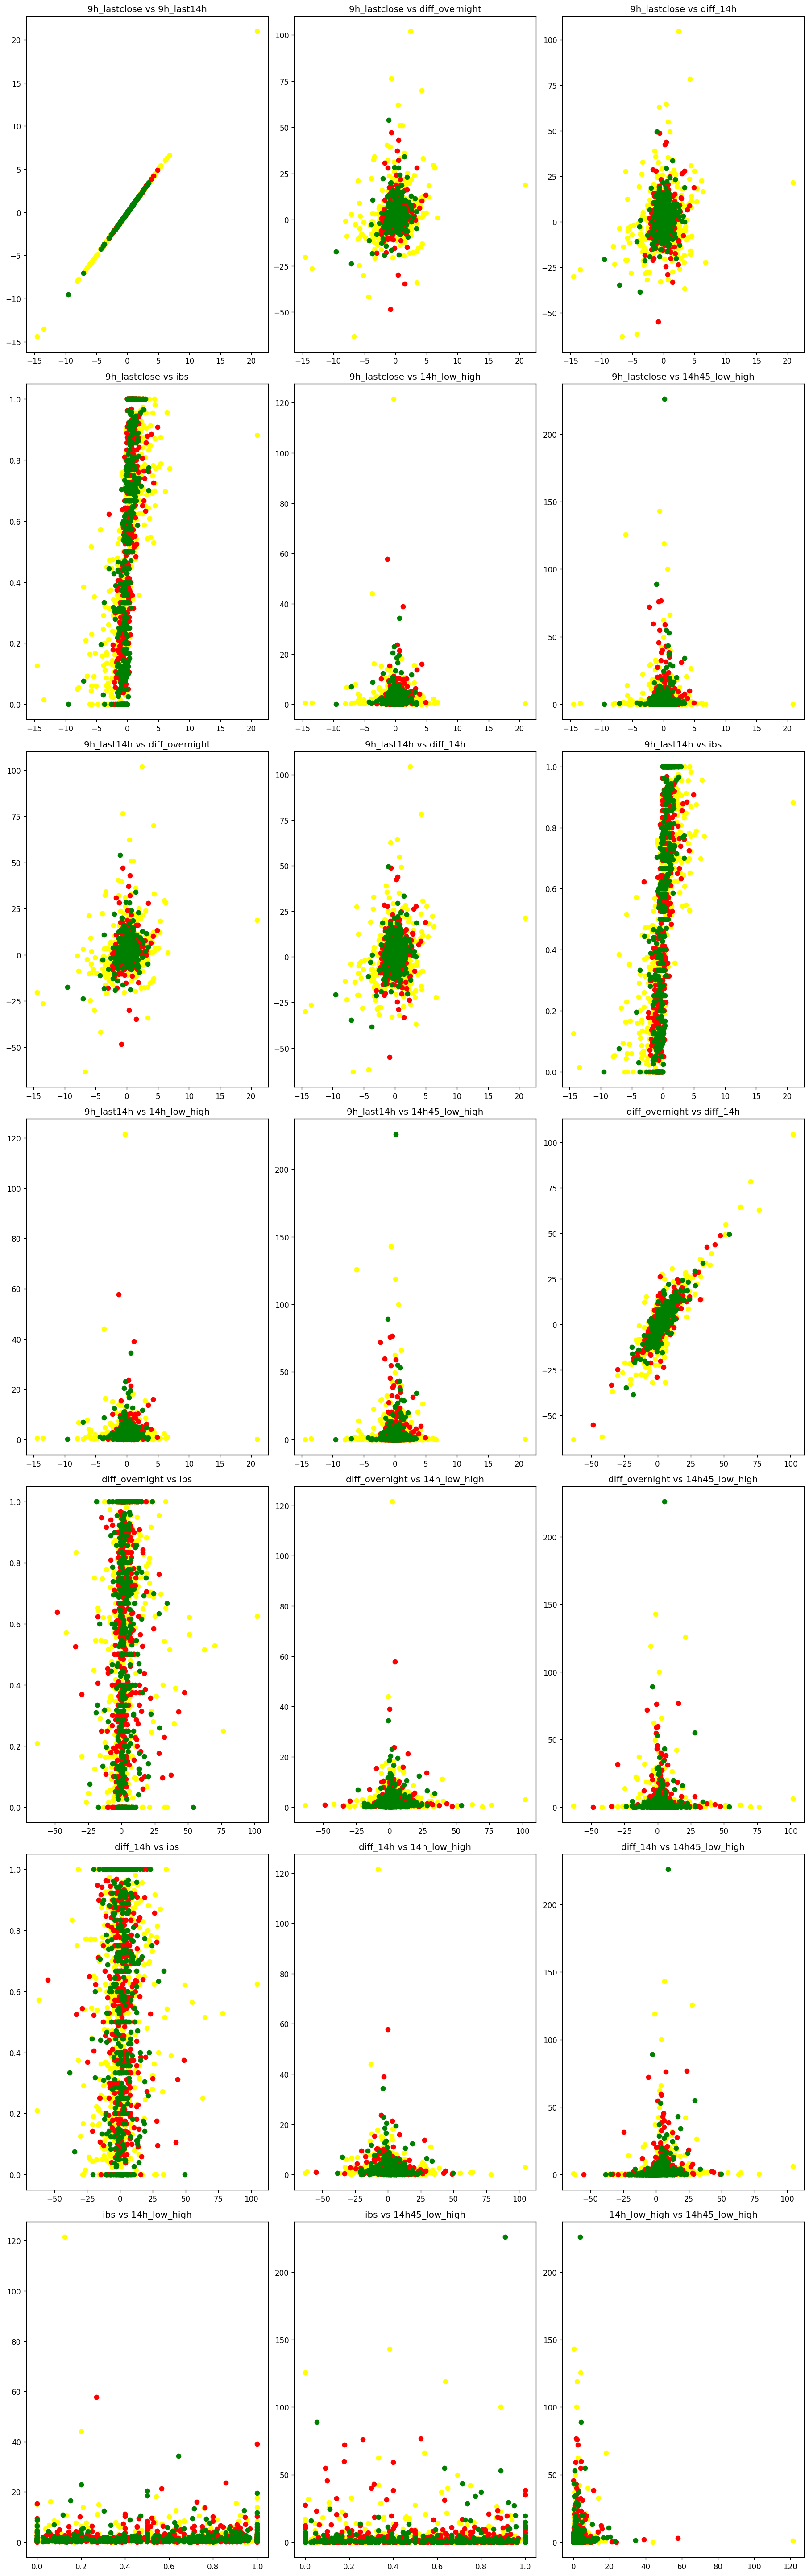

In [35]:
plt.rcParams['figure.figsize'] = [15, 48]
selected_columns = ['9h_lastclose', '9h_last14h', 'diff_overnight', 'diff_14h', 'ibs', '14h_low_high', '14h45_low_high']
COL_GRID_PLOT = 3
l = len(selected_columns)
total_grid = (l*(l-1))/2
ROW_GRID_PLOT = math.ceil(total_grid/COL_GRID_PLOT)
index = 1
for k in range(len(selected_columns)):
    for h in range(k+1, len(selected_columns)):
        column_x = selected_columns[k]
        column_y = selected_columns[h]
        plt.subplot(ROW_GRID_PLOT, COL_GRID_PLOT, index)
        plt.title("{} vs {}".format(column_x, column_y))
        plt.scatter(group_none[column_x], group_none[column_y], c='yellow')
        plt.scatter(group_high[column_x], group_high[column_y], c='red')
        plt.scatter(group_low[column_x], group_low[column_y], c='green')
        index = index+1

In [36]:
day_data

,Open,Close,High,Low,Close_9h,Close_14h,RSI,trend_diff,total_above_ma,total_below_ma,...,rate_b,rate_c,rate_d,14h_low_high,14h45_low_high,9h_lastclose,9h_last14h,rate_e,rate_f,rate_g
Date,,,,,,,,,,,,,,,,,,,,,
2018-08-16,942.4,947.0,947.3,935.5,942.0,944.0,17.896244,30.0,82.0,52.0,...,-0.016701,-1.063694,0.414414,2.413043,0.000000,-0.422565,-0.417667,-0.993631,-2.409765,-8.224632
2018-08-17,952.2,947.0,954.6,945.0,953.0,947.4,77.237192,-14.0,68.0,82.0,...,0.011248,0.932203,2.000000,2.575758,38.333333,0.844773,0.847458,0.830508,3.186743,4.780115
2018-08-20,946.1,945.0,951.5,942.6,945.8,946.4,35.866439,-30.0,60.0,90.0,...,-0.006721,-0.750000,3.000000,0.333333,0.263158,-0.316790,-0.316656,-0.635417,-0.631712,-0.842283
2018-08-22,959.5,957.0,960.6,953.6,959.3,957.8,84.573704,34.0,92.0,58.0,...,0.013952,1.516854,-10.214286,0.745098,0.369231,-0.211640,-0.211327,1.505618,7.549760,6.810622
2018-08-23,957.0,960.6,963.5,955.8,957.0,962.5,49.488219,32.0,91.0,59.0,...,-0.002606,-0.328571,-0.000000,1.500000,0.944444,0.000000,0.000000,-0.357143,0.000000,-0.417929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-24,1283.3,1283.5,1287.4,1273.3,1282.7,1281.0,27.407013,-29.0,60.0,89.0,...,-0.014445,-0.826271,0.127119,2.064935,0.210256,-0.467217,-0.462963,-0.771186,-0.580540,-5.147457
2024-07-25,1276.9,1276.6,1278.9,1270.7,1276.5,1273.2,36.015434,-18.0,66.0,84.0,...,-0.005299,-0.439716,-2.800000,1.203125,2.615385,-0.311648,-0.312256,-0.453901,-2.733628,-1.757332
2024-07-29,1289.9,1287.8,1294.7,1287.8,1291.2,1292.9,83.969729,20.0,85.0,65.0,...,0.011199,1.792683,4.294118,0.438596,2.565217,1.018330,1.021049,1.585366,5.726388,7.059931
